In [1]:
import numpy as np
import scipy.interpolate as interp
from scipy.integrate import simps
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

from avlwrapper import (Geometry, Surface, Section,  FileAirfoil, Control,
                                       Point, Spacing, Session, Case, Parameter,
                                       ParameterSweep, ProfileDrag)
gSI = 9.81

In [2]:
#preprocessing airfoil data
airfoil = np.genfromtxt("../in/6043.dat")
#XXX
col = 0
for i in range(len(airfoil)-1):
    if airfoil[i,0]<airfoil[i+1,col]:
        n=i
        break
else: #default if transition is not found
    n= len(airfoil)//2
top = airfoil[:(n+1),:]
bot = airfoil[(n):,]

#reverse the arrays
top = top[::-1,:]
bot = bot #or not

In [3]:
#Caclulate the thickness of the airfoil
xc = np.linspace(0,1,num=500)
options = {"kind":"linear", "fill_value":"extrapolate"}
nbot = interp.interp1d(bot[:,0].T,bot[:,1],**options)
ntop = interp.interp1d(top[:,0].T,top[:,1],**options)

In [4]:
def I(pos,t):
    dA = np.sqrt((pos**2)[:,0] + (pos**2)[:,1])*t
    return np.array([np.sum(dA*pos[:,1]**2), np.sum(dA*pos[:,0]**2), np.sum(dA*pos[:,1]*pos[:,0])])

def analysis(c=0.25, cbeam = 0.24, stripT=0.5e-3,beamT=3e-3,ntop=ntop,nbot=nbot,
             beamWidth = 3e-2, stripWidth = 3e-3, debug=False):

    #using reinforcements for roation at the end of the wing
    #get xy for top and bottom strips:
    c75 = 0.75*c
    #assume small angles
    topStrip = np.array([[c75-stripWidth,ntop(0.75-stripWidth/c)*c],[c75,ntop(0.75)*c]])
    botStrip = np.array([[c75-stripWidth,nbot(0.75-stripWidth/c)*c],[c75,nbot(0.75)*c]])

    #now compute the centroid of this specific structure
    stripT = 5e-4 #assume constant thickness
    stripCentroid = (np.average(topStrip,axis=0) + np.average(botStrip,axis=0))/2

    #calculate main postions
    cstart = cbeam -beamWidth/c/2 
    cend = cbeam +beamWidth/c/2 
    cspace = np.linspace(cstart,cend)

    beamT = 3e-3
    topbeam =  np.vstack([cspace, ntop(cspace)]).T*c
    botbeam =  np.vstack([cspace, nbot(cspace)]).T*c
    beamCentroid = (np.average(topbeam,axis=0) + np.average(botbeam,axis=0))/2

    centroid = (beamCentroid*beamWidth*beamT +stripCentroid*stripWidth*stripT)/(beamWidth*beamT+stripWidth*stripT)


    #calculating the second moment of area of the structural form
    Is =(I(topbeam-centroid,beamT) + 
        I(botbeam-centroid,beamT) + 
        I(topStrip-centroid,stripT) +
        I(topStrip-centroid,stripT))

    Ixx = Is[0]
    Iyy = Is[1]
    Ixy = Is[2]

    #calculate x_max and y_max
    positions = np.vstack([topStrip,botStrip,topbeam,botbeam]) - centroid

    M = np.max(positions,axis=0)
    m = np.min(positions,axis=0)

    x_max = (M[0],m[0])
    y_max = (M[1],m[1])

    #compute the area of the foam sections
    a = lambda arr: np.trapz(arr[:,1],arr[:,0])
    A = np.abs(a(topStrip[::-1]) - a(botStrip)) + np.abs(a(topbeam[::-1]) - a(botbeam))
    results = {"centroid" : centroid,
               "Ixx" : Ixx,
               "Iyy" : Iyy,
               "Ixy" : Ixy,
               "x_max" : x_max,
               "y_max" : y_max,
               "A" : A}
    if debug:
        debug = {"topStrip" : topStrip,
                "botStrip" : botStrip,
                "topbeam" : topbeam,
                "botbeam" : botbeam,
                "stripCentroid" : stripCentroid,
                "beamCentroid" : beamCentroid}
        return results, debug
    
    return results
c= 0.18
res, ana = analysis(c=c,stripWidth=3e-3, debug=True)
centroid = res["centroid"]
x_max = res["x_max"]
y_max = res["y_max"]
topStrip = ana["topStrip"]
botStrip = ana["botStrip"]
topbeam = ana["botbeam"]
botbeam = ana["topbeam"]
stripCentroid = ana["stripCentroid"]
beamCentroid = ana["beamCentroid"]


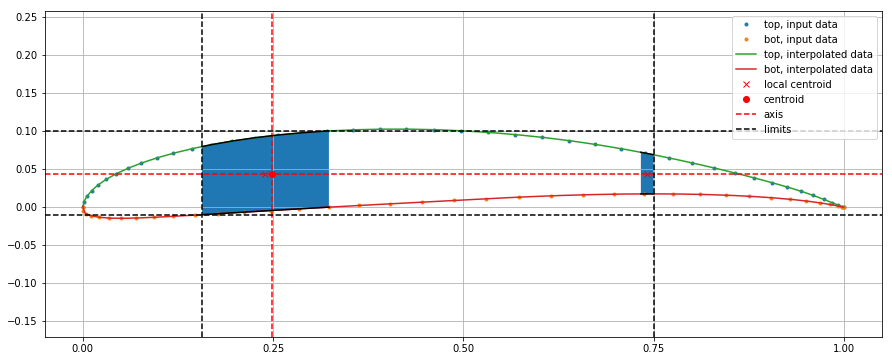

In [5]:
#check everyting looks fine
fig, ax = plt.subplots()
ax.plot(top[:,0],top[:,1],'.',label="top, input data")
ax.plot(bot[:,0],bot[:,1],'.',label="bot, input data")
ax.plot(xc,ntop(xc),label="top, interpolated data")
ax.plot(xc,nbot(xc),label="bot, interpolated data")

#plot reinforcements
ax.plot(topStrip[:,0]/c,topStrip[:,1]/c,'k-')
ax.plot(botStrip[:,0]/c,botStrip[:,1]/c,'k-')

#plot filled sections
patches = []; 
patches.append(Polygon(np.vstack([topStrip,botStrip[::-1,:]])/c,True))

#centroids
ax.plot(stripCentroid[0]/c,stripCentroid[1]/c,"xr",label="local centroid")
ax.plot(beamCentroid[0]/c,beamCentroid[1]/c,"xr")
ax.plot(centroid[0]/c,centroid[1]/c,"or",label="centroid")
ax.axvline(centroid[0]/c,color='r',linestyle="--",label="axis")
ax.axhline(centroid[1]/c,color='r',linestyle="--")

#add main reinforcing strips
ax.plot(topbeam[:,0]/c, topbeam[:,1]/c,"k-")
ax.plot(botbeam[:,0]/c, botbeam[:,1]/c,"k-")

#add filled secion
patches.append(Polygon(np.vstack([topbeam,botbeam[::-1,:]])/c,True))

#top and bottom
#ymax
ax.axhline((y_max[0]+centroid[1])/c,color="k",linestyle="--",label="limits")
ax.axhline((y_max[1]+centroid[1])/c,color="k",linestyle="--")
#xmax
ax.axvline((x_max[0]+centroid[0])/c,color="k",linestyle="--")
ax.axvline((x_max[1]+centroid[0])/c,color="k",linestyle="--")

p=PatchCollection(patches)
ax.add_collection(p)
ax.set_xticks(ticks=[0,0.25,0.5,0.75,1.0])
ax.set_ylim((-0.2,0.2))
ax.grid(True)
ax.legend()
ax.axis("equal")
fig.set_size_inches((15,6))

In [6]:
#Now dothis over the entire beam
croot = 0.18
ctip = 0.1
xtip = 0.7
num = 100
xs = np.linspace(0,xtip,num=num)
cs = np.linspace(croot,ctip,num=num)

cbeam = 0.24
bWidth = 3e-2
SWidth = 3e-3
#find properties along the wing
def analyseWing(c=0.25, cbeam = 0.24, stripT=0.5e-3,beamT=3e-3,ntop=ntop,nbot=nbot,
             beamWidth = 3e-2, stripWidth = 3e-3, debug=False):
    #do some checks
    assert(type(c) == np.ndarray)
    
    #convert constants to np.ndarray
    shape = c.shape
    cbeam = cbeam * np.ones(shape)
    stripT =stripT * np.ones(shape)
    beamT = beamT * np.ones(shape)
    beamWidth = beamWidth * np.ones(shape)
    stripWidth = stripWidth * np.ones(shape)
    results = []
    for i in range(len(c)):
        results.append(analysis(c=c[i], cbeam = cbeam[i], stripT=stripT[i],beamT=beamT[i],ntop=ntop,nbot=nbot,
             beamWidth = beamWidth[i], stripWidth = stripWidth[i], debug=debug))
    return results

ana = analyseWing(c=cs)
#split into a numpy array
data = np.array([[i['Ixx'],i['Iyy'],i['Ixy'],i['x_max'][0],i['x_max'][1],i['y_max'][0],i['y_max'][1],i['A']] for i  in ana])
del ana #free memory

#extract usefull data
Ixx = data[:,0]
Iyy = data[:,1]
Ixy = data[:,2]
Xmax = data[:,3]
xmax = data[:,4]
Ymax = data[:,5]
ymax = data[:,6]
A = data[:,7]

In [7]:
#begin building sections
AF = FileAirfoil("../in/6043.dat")
Sref = (ctip+croot)*xtip
cref = (ctip+ croot)/2
#figure out the lift distribution
rootSection = Section(leading_edge_point=Point(croot*0.25,0,0),
                      chord=croot,
                      airfoil=AF)
tipSection = Section(leading_edge_point=Point(ctip*0.25,xtip,0),
                     chord=ctip,
                     airfoil=AF)
wingSurface = Surface(name="Wing",
                      n_chordwise=15,
                      chord_spacing=Spacing.cosine,
                      n_spanwise=15,
                      span_spacing=Spacing.cosine,
                      y_duplicate=0.0,
                      sections=[rootSection,tipSection])
#fuselage = Body("fuselage",10,0.1)
geometry = Geometry(name="Wing",
                         reference_area=xtip*(croot+ctip),
                         reference_chord=Sref,
                         reference_span=xtip*2,
                         reference_point=Point(0, 0, 0),
                         surfaces=[wingSurface])
cruise_case = Case(name='Cruise', alpha=+2)
session = Session(geometry=geometry, cases=[cruise_case])
results = session.get_results()
session._write_geometry(name="avl_input.avl")

In [8]:
CL = results['Cruise']['SurfaceForces']['Wing']['CL']
CD = results['Cruise']['SurfaceForces']['Wing']['CD']

#extract sectionnal data from AVL
cl = np.array(results['Cruise']['StripForces']['Wing']['cl'])
c_cl = np.array(results['Cruise']['StripForces']['Wing']['c cl'])
Yle = np.array(results['Cruise']['StripForces']['Wing']['Yle'])
c = np.array(results['Cruise']['StripForces']['Wing']['Chord'])

data = np.stack((Yle,cl,c_cl,c))
data = data[:,np.argsort(data[0])]
Yle = data[0,:]
cl = data[1,:]
c_cl = data[2,:]
c = data[3,:]

#convert lift distribution to load distribution
U_infty = 60
rho_infty = 1.2
q_infty = 0.5 * U_infty**2 * rho_infty
L_dist = cl *q_infty*c


#interpolate the lift distribution
options = {"kind":"cubic", "fill_value":"extrapolate"}
LInterp = interp.interp1d(Yle[len(Yle)//2:],L_dist[len(Yle)//2:],**options)
Lkg = CL*q_infty*Sref/9.81
#check that the lift is equal to the load
print("LIFT Integrated: {} [kg]".format(simps(L_dist,Yle)/9.81))
print("LIFT Interpolated Integrated: {} [kg]".format(simps(LInterp(xs),xs)/9.81*2))
print("LIFT AVL: {} [kg]".format(Lkg))

LIFT Integrated: 7.4352053742336315 [kg]
LIFT Interpolated Integrated: 7.484588802552709 [kg]
LIFT AVL: 7.474612844036697 [kg]


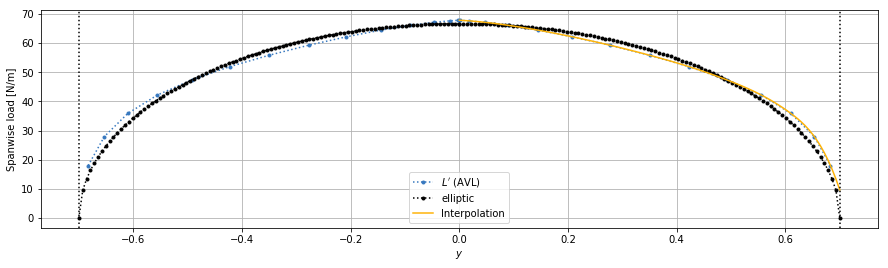

In [9]:
fig, ax = plt.subplots()
elliptic = (Lkg*9.81*2)/(np.pi*xtip**2)*np.sqrt(xtip**2-xs**2)
ax.plot(Yle,L_dist,'-',linestyle=":",marker=".",c='xkcd:windows blue',label=r"$L'$ (AVL)")
ax.plot(xs,elliptic,'-',linestyle=":",marker=".",c='k',label=r"elliptic")
ax.plot(-xs[::-1],elliptic[::-1],'-',linestyle=":",marker=".",c='k')
ax.plot(xs,LInterp(xs),c='xkcd:amber',label='Interpolation')
ax.axvline(-xtip,color='k',linestyle=':')
ax.axvline(xtip,color='k',linestyle=':')
ax.legend()
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'Spanwise load [N/m]')
ax.grid(True)
fig.set_size_inches((15,4))
plt.show()

In [36]:
#Calculate load distributions
safetyFactor = 1.2
gmax = 2.5

#Materials
fibre = {'E' : 33e9, 'rho' : 1666.6,'sigTens': 400,'sigComp' : 200}
foam = {'E' : 1.9e9, 'rho' : 30.0,'sigTens': 22,'sigComp' : 22}

#mass distribution:
#mass dritribution is given by
# specific surface*skin_mass
# specific foam area*density_foam
# specific fibre surface*fibre density
def wingMass(A, xs, foam, fibre, beamT=3e-3, beamWidth=3e-2, stripT= 5e-4, stripWidth=3e-3):
    #Compute the mass distribution
    foamMass  = A*foam["rho"]
    fibreMass = (stripT*stripWidth + beamT*beamWidth)*2*fibre["rho"]
    skinMass = 0 #XXX
    m = foamMass+fibreMass+skinMass
    return m, np.trapz(m,xs)

print("The mass of the wing is: {:f} [kg]".format(wingMass(A,xs,foam,fibre)[1]))

dweight = -gSI*wingMass(A,xs,foam,fibre)[0]
dlift = LInterp(xs)


dloadz = dweight #+ dlift

#compute the moment distribution
xMoments = np.zeros(xs.shape)

for i in range(len(xs)):
    xMoments[i] = np.trapz(dloadz[i:]*xs[i:],xs[i:])
    
#compute the stresses:
#we will extract two arrays of stresses (compressive and tensile)
sigTens = ymax*xMoments/Ixx
sigComp = Ymax*xMoments/Ixx

#TODO: Check sigma compute, seems to be wrong
# moments could be right so check Ixx and Ymax first.
# dweight is linear but does not go down that much
#TODO: General Cleanup

The mass of the wing is: 0.221902 [kg]


No handles with labels found to put in legend.


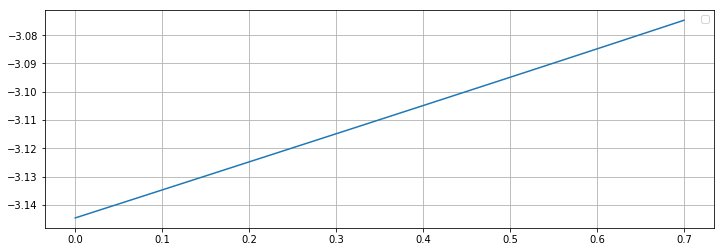

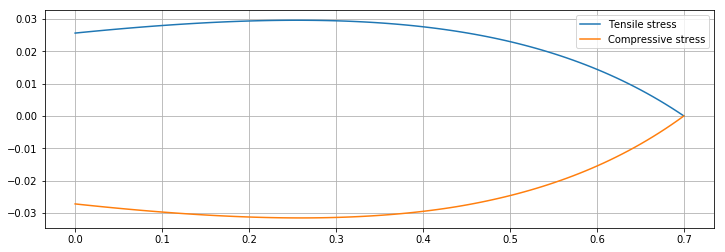

In [38]:
#Check other things
fig, ax = plt.subplots()
ax.plot(xs, dweight)
ax.grid()
fig.set_size_inches((12,4))
plt.show()

#Check stress
fig, ax = plt.subplots()
ax.plot(xs,sigTens/1e6,label="Tensile stress")
ax.plot(xs,sigComp/1e6,label="Compressive stress")
#ax.plot(xs,np.max(np.vstack([np.abs(sigTens),np.abs(sigComp)]),axis=0)/1e6,label="Envelope")
#ax.axhline(fibre["sigTens"])
ax.grid()
ax.legend()
fig.set_size_inches((12,4))
plt.show()

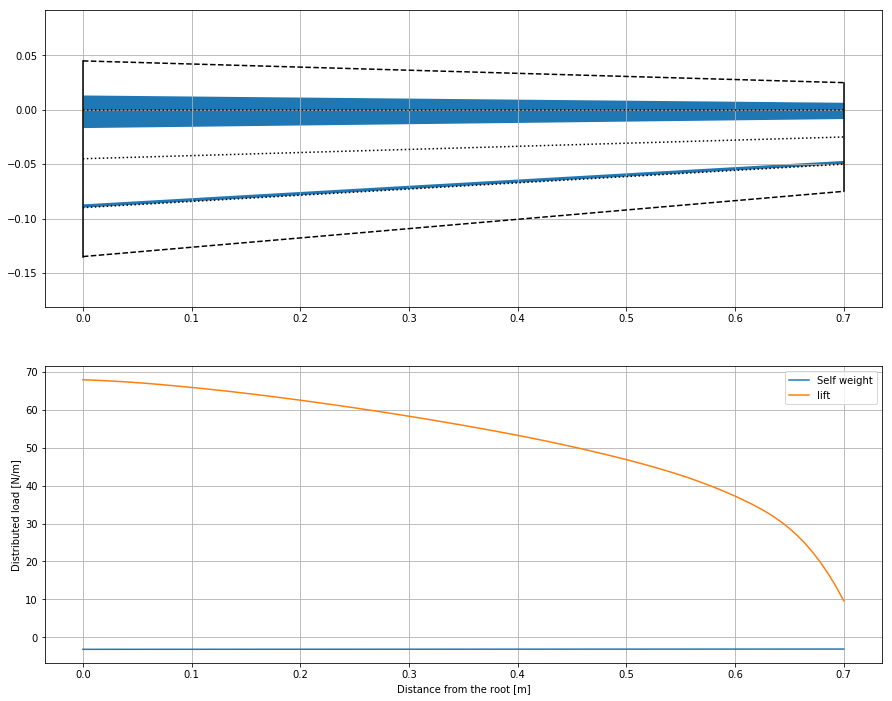

In [20]:
#plots to check what's up
fig, axs = plt.subplots(nrows=2)
(ax1,ax2) = axs
ax1.plot(xs,cs*0.25,"--k")
ax1.plot(xs,-cs*0.75,"--k")
ax1.plot(xs,-cs*0.5,":k")
ax1.plot(xs,-cs*0.25,":k")
ax1.plot(xs,cs*0,":k")

patches = [];
points = [[0,croot*(cbeam-0.25)+bWidth/2],
          [0,croot*(cbeam-0.25)-bWidth/2],
          [xtip,ctip*(cbeam-0.25)-bWidth/4],
          [xtip,ctip*(cbeam-0.25)+bWidth/4]]
patches.append(Polygon(np.array(points),True,color="k"))

pts = [[0,-0.5*croot+SWidth],
       [0,-0.5*croot],
       [xtip,-0.5*ctip],
       [xtip,-0.5*ctip+SWidth]]
patches.append(Polygon(np.array(pts),True,color="k"))

ax1.plot([0,0],[croot*0.25,-croot*0.75],'k')
ax1.plot([xtip,xtip],[ctip*0.25,-ctip*0.75],'k')


p=PatchCollection(patches)
ax1.add_collection(p)
ax1.axis("equal")
ax1.grid(True)


ax2.plot(xs,dweight,label="Self weight")
ax2.plot(xs,dlift,label="lift")
ax2.legend()
ax2.set_ylabel(r"Distributed load [N/m]")
ax2.set_xlabel(r"Distance from the root [m]")
ax2.grid()
fig.set_size_inches((15,12))
plt.show()